# 📖 References

- https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb
- https://github.com/huggingface/notebooks/blob/main/examples/translation-tf.ipynb
- https://huggingface.co/gogamza/kobart-base-v2

# 0️⃣ Prerequisite

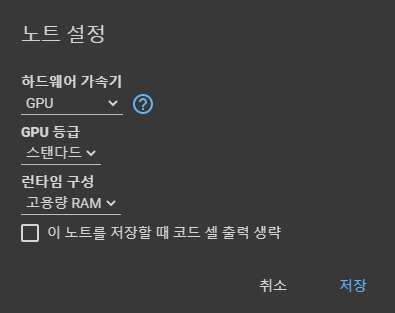

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 31 02:56:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 3')

In [ ]:
!pip install -q datasets torchinfo transformers sacrebleu sentencepiece wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.0 MB/s eta 0:0

In [ ]:
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from easydict import EasyDict as edict
from sklearn.model_selection import train_test_split
from torchinfo import summary
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
)

import numpy as np
import pandas as pd
import random
import sentencepiece
import torch

In [ ]:
# Log in to your W&B account
import wandb

wandb.login(key='eeef6909a6674c953c756358e614461bdced83c4')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
def seed_everthing(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everthing(42)

# 1️⃣ Loading the dataset

In [ ]:
"""df_a = pd.read_csv('output/df_spoken-written_a.csv')
df_a.columns = ['id', 'spoken', 'written']

df_b = pd.read_csv('output/df_spoken-written_b.csv')
df_b.columns = ['id', 'spoken', 'written']

df = pd.concat([df_a, df_b])"""

"df_a = pd.read_csv('output/df_spoken-written_a.csv')\ndf_a.columns = ['id', 'spoken', 'written']\n\ndf_b = pd.read_csv('output/df_spoken-written_b.csv')\ndf_b.columns = ['id', 'spoken', 'written']\n\ndf = pd.concat([df_a, df_b])"

In [ ]:
"""df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)
df_train.to_csv('input/df_spoken-written_train.csv', index=False)
df_validation.to_csv('input/df_spoken-written_validation.csv', index=False)"""

"df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)\ndf_train.to_csv('input/df_spoken-written_train.csv', index=False)\ndf_validation.to_csv('input/df_spoken-written_validation.csv', index=False)"

In [ ]:
df_train = pd.read_csv('input/df_spoken-written_train.csv')
df_validation = pd.read_csv('input/df_spoken-written_validation.csv')

In [ ]:
ds_train = Dataset.from_dict({'translation': df_train[['spoken', 'written']].to_dict('records')})
ds_validation = Dataset.from_dict({'translation': df_validation[['spoken', 'written']].to_dict('records')})

In [ ]:
raw_datasets = DatasetDict({
    "train": ds_train,
    "validation": ds_validation})

In [ ]:
print("Number of Train Samples:", len(raw_datasets['train']))
print("Number of Validation Samples:", len(raw_datasets['validation']))
print(raw_datasets['train'][0])
print(raw_datasets['validation'][0])

Number of Train Samples: 11012
Number of Validation Samples: 2754
{'translation': {'spoken': '차가 없어서 그러는데, 택시 외에 쇼핑센터로 가는 방법이 있나요?', 'written': '나는 차가 없지만 택시 외에 쇼핑 센터에 갈 수있는 방법이 있습니까?'}}
{'translation': {'spoken': '이 불고기 맛이 너무 환상적인데 어떻게 만드셨나요?', 'written': '이 불고기 맛은 매우 환상적입니다.어떻게 만들었습니까?'}}


In [ ]:
del df_train, df_validation
del ds_train, ds_validation

import gc
gc.collect()

13

# 2️⃣ Preprocessing the data

In [ ]:
model_checkpoint = 'lcw99/t5-base-korean-paraphrase'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
"""if 't5' in model_checkpoint:
    prefix = "translate Korean to Korean: "
else:
    prefix = """""

'if \'t5\' in model_checkpoint:\n    prefix = "translate Korean to Korean: "\nelse:\n    prefix = '

In [ ]:
prefix = ""

In [ ]:
suffix = tokenizer.eos_token

In [ ]:
max_input_length = 128
max_target_length = 128
source_lang = "spoken"
target_lang = "written"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] + suffix for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(raw_datasets['train'][:2])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[13425, 222, 2145, 222, 13232, 13, 222, 3956, 222, 624, 279, 222, 965, 1192, 293, 222, 975, 222, 933, 262, 222, 2382, 296, 32, 1], [1205, 222, 2314, 389, 222, 2315, 305, 222, 548, 5879, 222, 1374, 222, 985, 222, 1688, 222, 2438, 296, 15, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[1441, 222, 13425, 222, 3830, 222, 3956, 222, 624, 279, 222, 965, 222, 1192, 279, 222, 770, 222, 334, 491, 222, 933, 262, 222, 13334, 32, 1, 1], [699, 222, 2314, 278, 222, 2315, 222, 305, 222, 8755, 274, 222, 1374, 222, 985, 222, 1688, 278, 222, 738, 15, 1, 1]]}

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# 3️⃣ Fine-tuning the model

In [ ]:
"""metric = load_metric("sacrebleu")"""

'metric = load_metric("sacrebleu")'

In [ ]:
"""fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)"""

'fake_preds = ["hello there", "general kenobi"]\nfake_labels = [["hello there"], ["general kenobi"]]\nmetric.compute(predictions=fake_preds, references=fake_labels)'

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [ ]:
epochs = 30
batch_size = 16
accumulation = 4
seed = 42
model_name = model_checkpoint.split("/")[-1] + f"-finetuned-{source_lang}-to-{target_lang}"

args = Seq2SeqTrainingArguments(
    model_name,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=accumulation,
    weight_decay=0.01,
    num_train_epochs=epochs,
    logging_strategy='epoch',
    save_strategy='epoch',
    seed=seed,
    fp16=True,
    #predict_with_generate=True,
    dataloader_num_workers=2,
    #report_to = 'wandb',
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [ ]:
wandb.init(
    project="groom-proj3_traslation",
    name = model_name
)

wandb: Currently logged in as: yangdk02. Use `wandb login --relogin` to force relogin


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Cloning https://huggingface.co/yangdk/t5-base-korean-paraphrase-finetuned-spoken-to-written into local empty directory.
Using cuda_amp half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11012
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 5160
  Number of trainable parameters = 275579136
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a T5TokenizerFast to

Epoch,Training Loss,Validation Loss
0,1.054100,0.774273
1,0.768100,0.700787
2,0.695900,0.666030
3,0.645100,0.645646
4,0.606900,0.630906
5,0.575600,0.621731
6,0.547200,0.613836
7,0.522600,0.611485
8,0.499100,0.608268
9,0.479600,0.606045


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2754
  Batch size = 16
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to t5-base-korean-paraphrase-finetuned-spoken-to-written/checkpoint-172
Configuration saved in t5-base-korean-paraphrase-finetuned-spoken-to-written/checkpoint-172/config.json
Configuration s

TrainOutput(global_step=2580, training_loss=0.5696510374084, metrics={'train_runtime': 2174.0316, 'train_samples_per_second': 151.957, 'train_steps_per_second': 2.373, 'total_flos': 7111622837329920.0, 'train_loss': 0.5696510374084, 'epoch': 15.0})

In [ ]:
model.push_to_hub(f"yangdk/{model_name}")

Configuration saved in t5-base-korean-paraphrase-finetuned-spoken-to-written/config.json
Configuration saved in t5-base-korean-paraphrase-finetuned-spoken-to-written/generation_config.json
Model weights saved in t5-base-korean-paraphrase-finetuned-spoken-to-written/pytorch_model.bin
Uploading the following files to yangdk/t5-base-korean-paraphrase-finetuned-spoken-to-written: config.json,pytorch_model.bin,generation_config.json


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yangdk/t5-base-korean-paraphrase-finetuned-spoken-to-written/commit/d57aeff36caa7c9ba159be94a7eee9fb1a18ea5b', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='d57aeff36caa7c9ba159be94a7eee9fb1a18ea5b', pr_url=None, pr_revision=None, pr_num=None)

# 4️⃣ Inference

In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

# You can of course substitute your own username and model here if you've trained and uploaded it!
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = T5ForConditionalGeneration.from_pretrained(f"yangdk/{model_name}")
model.eval()
model.cuda()

loading file spiece.model from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--lcw99--t5-base-korean-paraphrase/snapshots/ad420deab76699ab627c7d74e61d91ce74f703d5/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--lcw99--t5-base-korean-paraphrase/snapshots/ad420deab76699ab627c7d74e61d91ce74f703d5/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--lcw99--t5-base-korean-paraphrase/snapshots/ad420deab76699ab627c7d74e61d91ce74f703d5/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--yangdk--t5-base-korean-paraphrase-finetuned-spoken-to-written/snapshots/d57aeff36caa7c9ba159be94a7eee9fb1a18ea5b/config.json
Model config T5Config {
  "_name_or_path": "lcw99/t5-base-korean-paraphrase",
  "architectures": [
    "T5ForConditionalGene

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--yangdk--t5-base-korean-paraphrase-finetuned-spoken-to-written/snapshots/d57aeff36caa7c9ba159be94a7eee9fb1a18ea5b/pytorch_model.bin
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_length": 512,
  "pad_token_id": 0,
  "transformers_version": "4.26.0"
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at yangdk/t5-base-korean-paraphrase-finetuned-spoken-to-written.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--yangdk--t5-base-korean-paraphrase-finetuned-spoken-to-written/snapshots/d57aeff36caa7c9ba159be94a7eee9fb1a18ea5b/generation_config.json
Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_length": 512,
  "pad_token_id": 0,
  "transformers_version": "4.26.0"
}



T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
input_text = '정기 시험이 엄청 어려웠어요.'
tokenized = tokenizer(input_text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
tokenized = {k: v.cuda() for k, v in tokenized.items()}
out = model.generate(**tokenized, max_length=128)[0, 1:-1].cpu()
print(tokenizer.decode(out, skip_special_tokens=True))

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_length": 512,
  "pad_token_id": 0,
  "transformers_version": "4.26.0"
}



정기 테스트는 매우 어려웠습니다.
